#### In this notebook, we will 
1. Use grid search to identify p,q parameters
2. Construct a SARIMA model
3. Make predictions for the AQI

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('DataAQ/CO-Florida.csv',index_col=0)

#### Differencing parameter
- Check stationary series with ADF test
- Find 'd' for the ARIMA model

In [8]:
def adfuller_test(y,alpha=0.05):
    """
    - With the Augmented Dickey Fuller (ADF) Test, we check the stationarity of TS data    
    - To test if data is stationary, we use hypothesis testing where our null hypothesis would be “time series data is non-stationary”. 
    - We will reject null hypothesis when p-value is less than 0.05 (p-value) which makes us take alternative hypothesis “time series data is stationary”.

    """
    from statsmodels.tsa.stattools import adfuller
    dftest = adfuller(y, autolag="AIC") #autolag = Method to use when automatically determining the lag
    p_value = dftest[1]
    # print(f"p value = {p_value:0.2f}")
    if p_value < alpha:
        return f"TS Stationary.: p value = {p_value:0.2f} < {alpha:0.2f}"
        
    else:
        return f"TS non-stationary: p value = {p_value:0.2f} > {alpha:0.2f}"
        

In [15]:
def plot_1st_2nd_diffs(y,rol=10):
    """
    y: a pandas series
    """
    fig,(ax1,ax2,ax3)=plt.subplots(nrows=3,ncols=1,figsize=(10,13))
    y.plot(ax=ax1,label="Original",color="black")
    # add mean
    y.rolling(window=rol,center=True).mean().plot(ax=ax1,label=f"rol. mean {rol} obsv",color="red",linewidth=2,linestyle="--")
    ax1.set_title(f"ADF Test: Original {adfuller_test(y=y)}")


    y.diff().plot(ax=ax2,label="1st diff",color="black")
    y.diff().rolling(window=rol,center=True).mean().plot(ax=ax2,label=f"rol. mean {rol} obsv",color="red",linewidth=2,linestyle="--")
    ax2.set_title(f"ADF Test: 1st diff {adfuller_test(y=y.diff().dropna())}")

    y.diff().diff().plot(ax=ax3,label="2nd diff",color="black")
    y.diff().diff().rolling(window=rol,center=True).mean().plot(ax=ax3,label=f"rol. mean {rol} obsv",color="red",linewidth=2,linestyle="--")
    ax3.set_title(f"ADF Test: 2nd diff {adfuller_test(y=y.diff().diff().dropna())}")

    ax1.legend()
    ax2.legend()
    ax3.legend()
    plt.show()

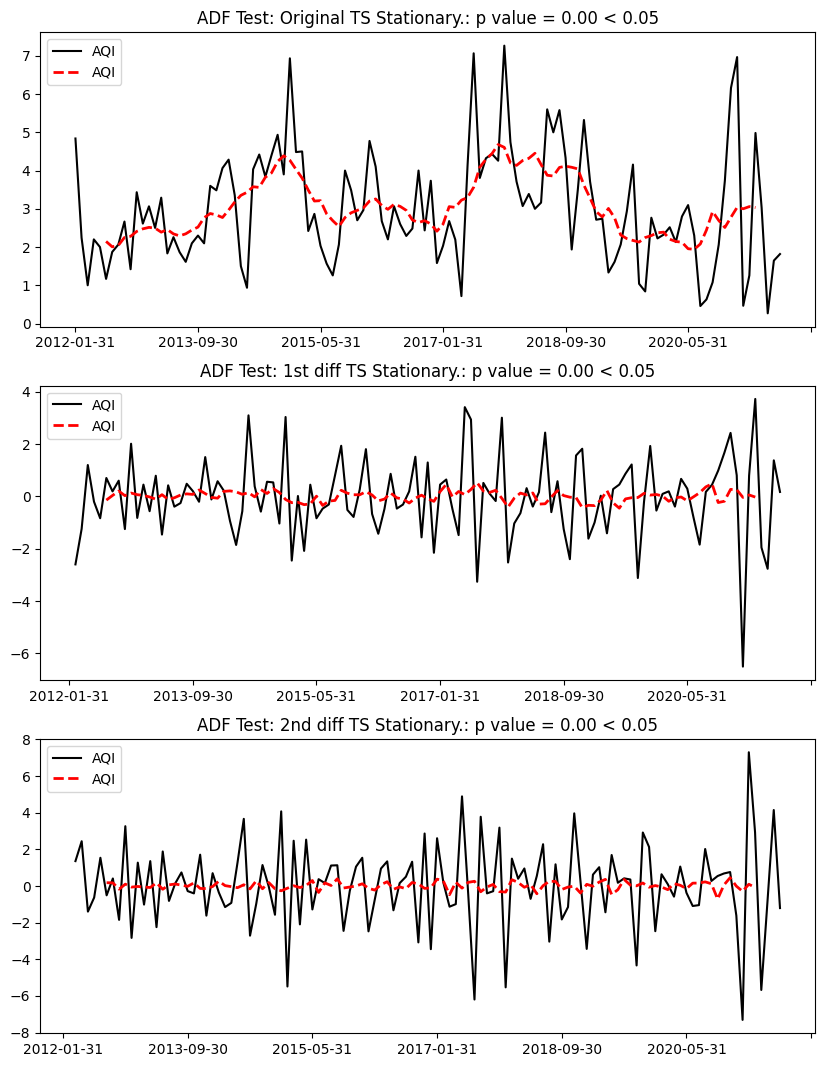

In [16]:
plot_1st_2nd_diffs(df)

#### Plot autocorrelations for original TS, and TS after 1st/2nd diff

In [57]:
def plot_acf_pacf_1st_2nd_diff(y,corr):
    """
    :param df: Data frame containing AQI data.
    :param corr: Type of correlaton: acf or pacf.
    :raise BadValueError: If corr not either acf or pacf.
    :return: ACF or PACF plots for original, 1st differenced and 2nd differnced data.
    """
    if corr not in ['acf','pacf']:
         raise ValueError('second argument must be acf or pacf')
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    fig,(ax1,ax2,ax3)=plt.subplots(nrows=3,ncols=1,figsize=(10,10))
    if corr=='acf':
        plot_acf(y,ax=ax1,label="Original");
        plot_acf(y.diff().dropna(),ax=ax2,label="1st_diff");
        plot_acf(y.diff().diff().dropna(),ax=ax3,label="2nd_diff");
        ax1.legend()
        ax2.legend()
        ax3.legend()
        plt.show()
    if corr=='pacf':
        plot_pacf(y,ax=ax1,label="Original", method="ywm");
        plot_pacf(y.diff().dropna(),ax=ax2,label="1st_diff", method="ywm");
        plot_pacf(y.diff().diff().dropna(),ax=ax3,label="2nd_diff", method="ywm");
        ax1.legend()
        ax2.legend()
        ax3.legend()
        plt.show()
    



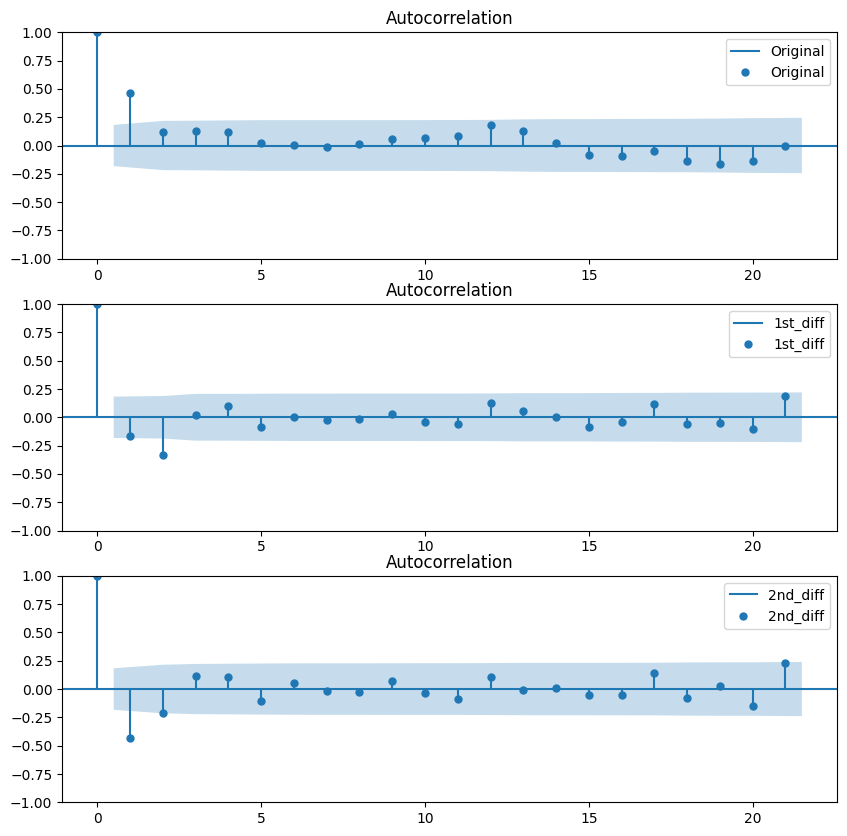

In [58]:
plot_acf_pacf_1st_2nd_diff(df,'acf')

From the stationary 1st differenced plot, initial estimate for q (MA parameter) is 2

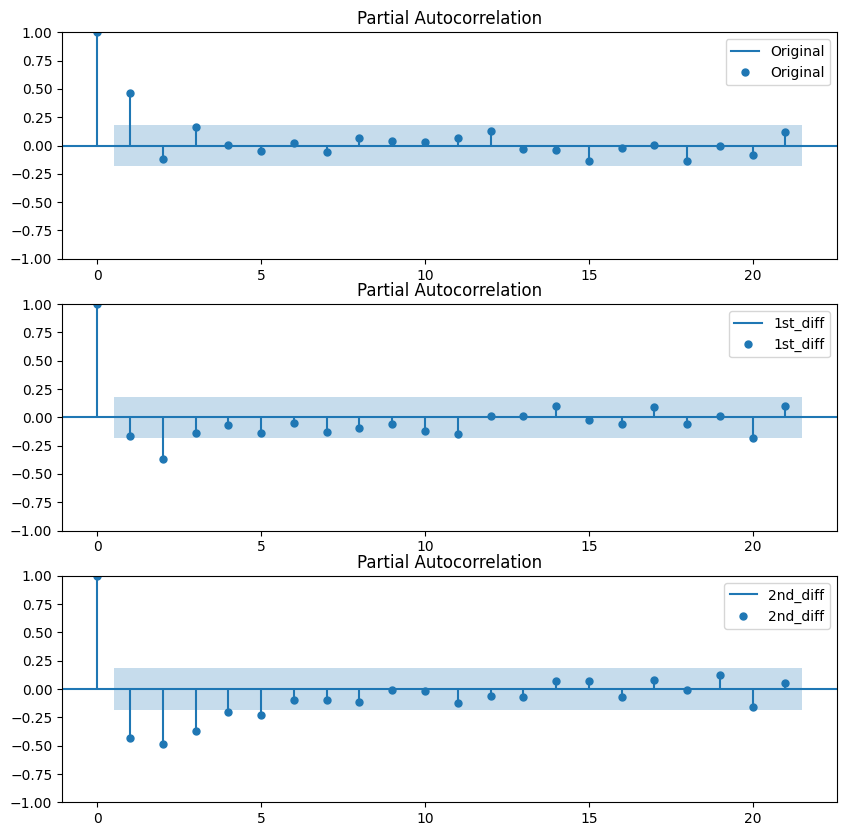

In [59]:
plot_acf_pacf_1st_2nd_diff(df,'pacf')

From the stationary 1st differenced plot, initial estimate for p (MA parameter) is 2

In [63]:
import pmdarima as pm

model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=12,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
# print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=425.638, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=423.374, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=409.970, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=423.672, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=413.819, Time=0.16 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=410.364, Time=0.40 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=411.030, Time=0.61 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=411.169, Time=0.18 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=412.304, Time=1.73 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=424.192, Time=0.13 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=422.550, Time=0.12 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=40

In [64]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  116
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -200.991
Date:                            Fri, 03 Feb 2023   AIC                            407.982
Time:                                    12:00:55   BIC                            416.216
Sample:                                01-31-2012   HQIC                           411.324
                                     - 08-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6929      0.048    -14.526      0.000      -0.786      -0.599
ma.S.L12       0.3011      0.130      2.314      0.021       0.046       0.556
sigma2         1.9004      0.203      9.381      0.000       1.503       2.297
===================================================================================
Ljung-Box (L1) (Q):                   6.64   Jarque-Bera (JB):                 8.01
Prob(Q):                              0.01   Prob(JB):                         0.02
Heteroskedasticity (H):               2.13   Skew:                             0.31
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

train_size=int(0.8*len(df))

train = df[:train_size]
test  = df[train_size:]

# model = ARIMA(train, order=(1, 1, 1))
model = sm.tsa.statespace.SARIMAX(train,order=(0,1,1),seasonal_order=(0,0,1,12))

fit_model = model.fit()

c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [69]:
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                AQI   No. Observations:                   92
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -147.443
Date:                            Fri, 03 Feb 2023   AIC                            300.887
Time:                                    12:03:17   BIC                            308.419
Sample:                                01-31-2012   HQIC                           303.926
                                     - 08-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5513      0.096     -5.749      0.000      -0.739      -0.363
ma.S.L12       0.3612      0.115      3.134      0.002       0.135       0.587
sigma2         1.4626      0.199      7.366      0.000       1.073       1.852
===================================================================================
Ljung-Box (L1) (Q):                   2.32   Jarque-Bera (JB):                 7.31
Prob(Q):                              0.13   Prob(JB):                         0.03
Heteroskedasticity (H):               1.73   Skew:                             0.56
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

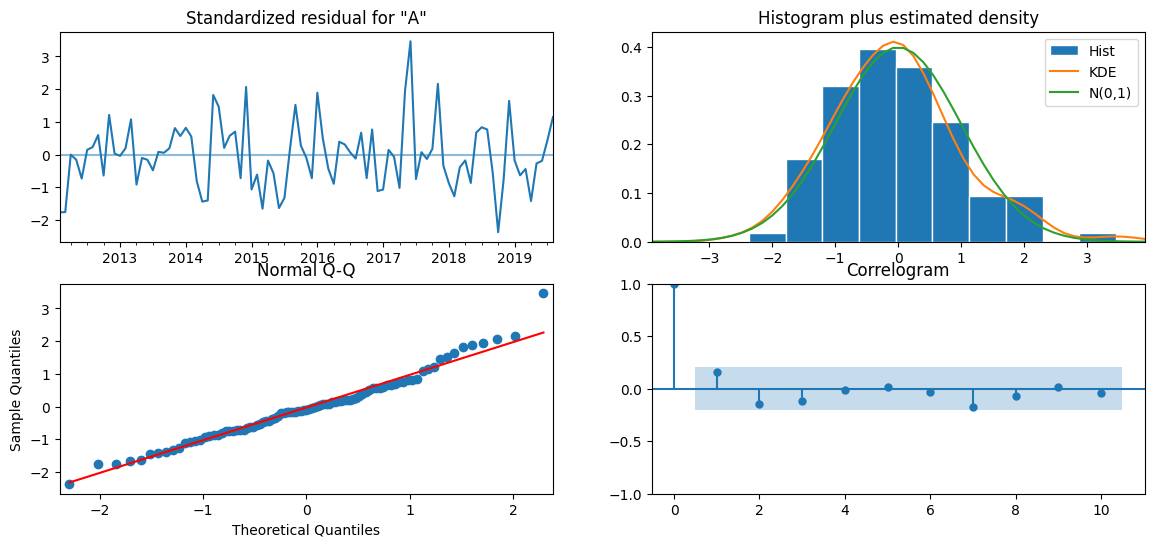

In [74]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6
fit_model.plot_diagnostics();

In [85]:
# In-sample one-step-ahead predictions
predict = fit_model.get_prediction()
predict_ci = predict.conf_int()
predict_dy = fit_model.get_prediction(dynamic='2018-11-30')
predict_dy_ci = predict_dy.conf_int()

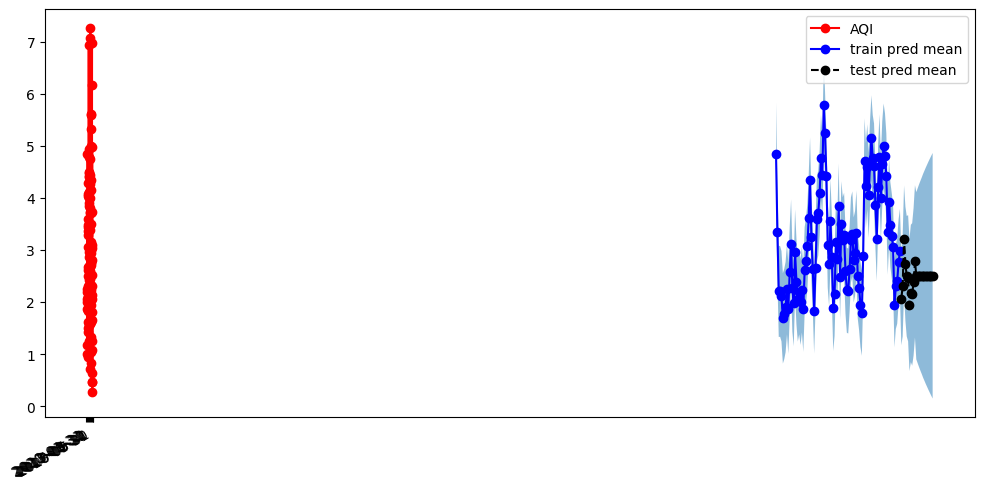

In [86]:
# In-sample one-step-ahead predictions, and out-of-sample forecasts
nforecast = len(test)
predict = fit_model.get_prediction(end=fit_model.nobs + nforecast)
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

# # Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
df.plot(ax=ax, style='-o', label='Observed',color="red")

predict.predicted_mean[1:-nforecast].plot(style='-o',color="blue",ax=ax,label="train pred mean")
predict.predicted_mean[-nforecast:].plot(style='o',color="black",linestyle='--',ax=ax,label="test pred mean")
ax.fill_between(predict_ci.index[1:], predict_ci.iloc[1:, 0], predict_ci.iloc[1:, 1], alpha=0.5)

ax.legend()

plt.show()

In [84]:
df.plot(ax=ax, style='-o', label='Observed',color="red")
plt.show()

<AxesSubplot: >

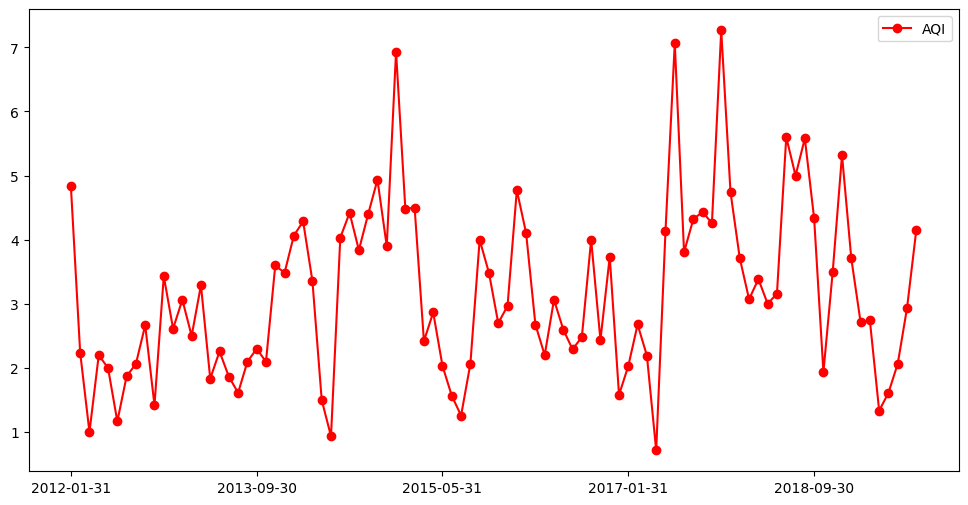

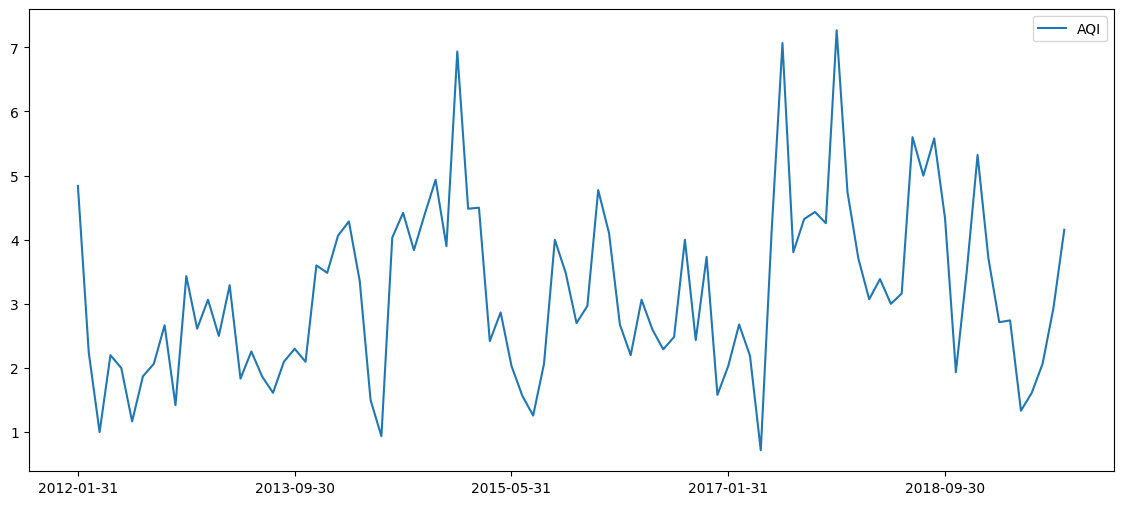

In [92]:
fig, ax = plt.subplots(figsize=(12,6))
# ax.xaxis.grid()
train.plot(ax=ax, style='-o', label='Observed',color="red")
train.plot()